# Exercise: Decision trees and model architecture

Our goal in this exercise is to use a decision tree classifier to predict whether an individual crime will be resolved, based on simple information such as where it took place and what kind of crime it was.

## Data visualization

As usual, let's begin by loading in and having a look at our data:

In [1]:
import pandas
#!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/graphing.py
#!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/san_fran_crime.csv

#Import the data from the .csv file
url = "https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/san_fran_crime.csv"
dataset = pandas.read_csv(url, delimiter="\t")

#Let's have a look at the data and the relationship we are going to model
print(dataset.head())
print(dataset.shape)

       Category  DayOfWeek  PdDistrict  Resolution           X          Y  \
0   WEAPON LAWS          5    SOUTHERN        True -122.403405  37.775421   
1   WEAPON LAWS          5    SOUTHERN        True -122.403405  37.775421   
2      WARRANTS          1     BAYVIEW        True -122.388856  37.729981   
3  NON-CRIMINAL          2  TENDERLOIN       False -122.412971  37.785788   
4  NON-CRIMINAL          5     MISSION       False -122.419672  37.765050   

   day_of_year  time_in_hours  
0           29      11.000000  
1           29      11.000000  
2          116      14.983333  
3            5      23.833333  
4            1       0.500000  
(150431, 8)


Our data looks to be a mix of _categorical_ variables like Crime `Category` or `PdDistrict`, and _numerical_ variables like the `day_of_year` (1-365) and `time_in_hours` (time of day, converted to a float). We also have `X` and `Y` which refer to GPS coordinates, and `Resolution` which is our label.

Let's visualize our data:

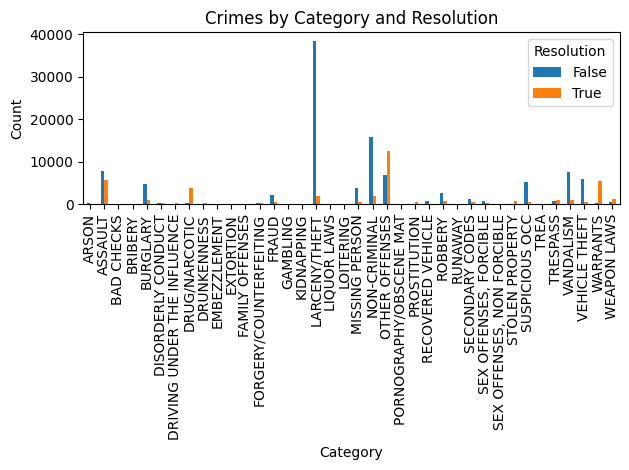

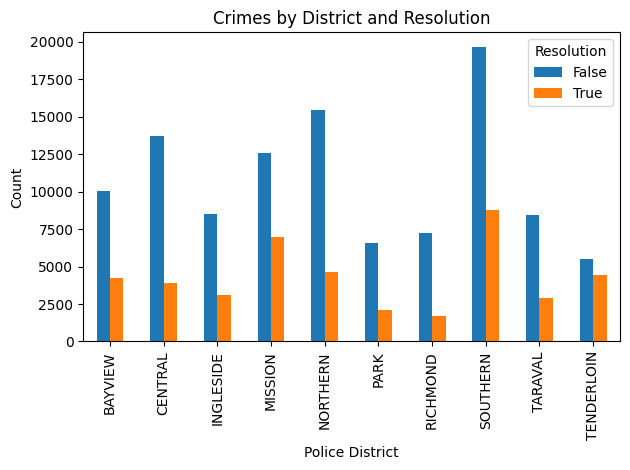

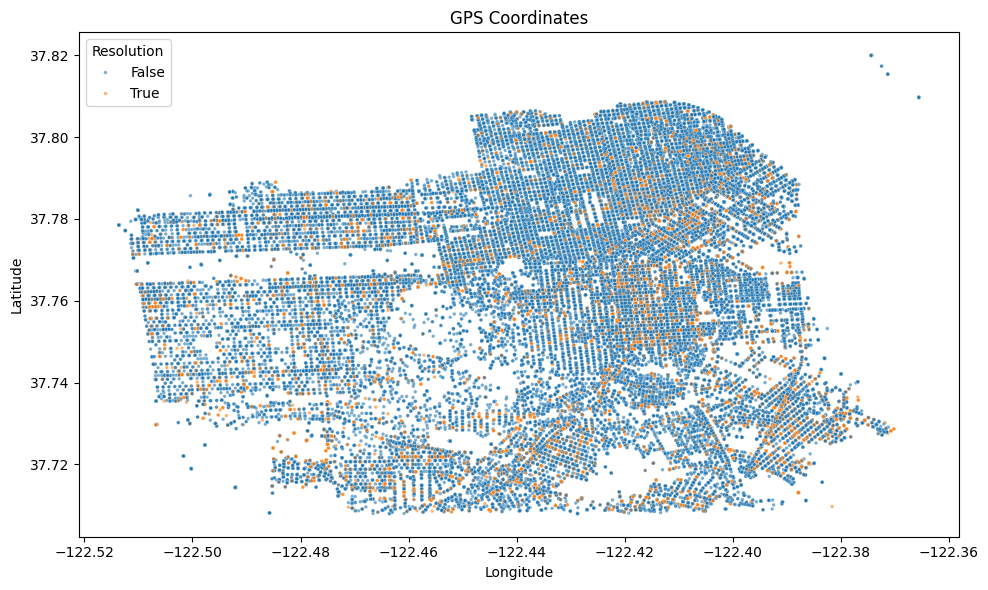

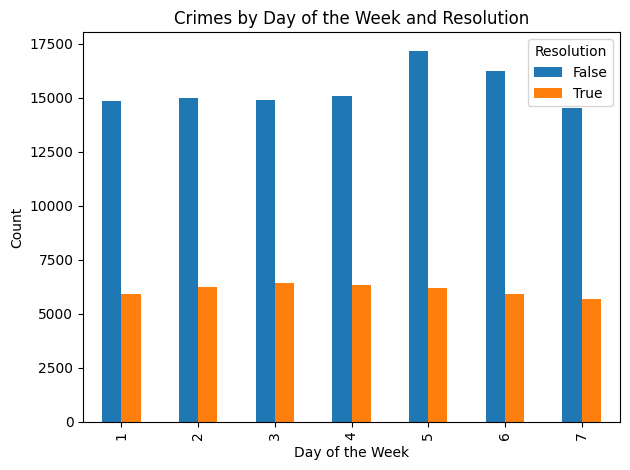

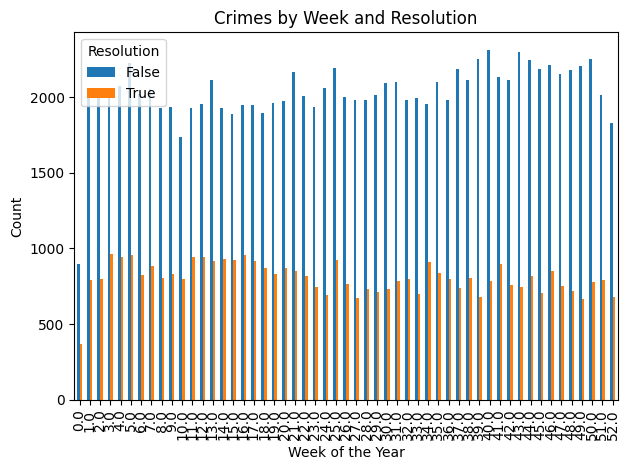

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Crime category
dataset.groupby(['Category', 'Resolution']).size().unstack().plot(kind='bar', stacked=False)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Crimes by Category and Resolution')
plt.tight_layout()
plt.show()

# District
dataset.groupby(['PdDistrict', 'Resolution']).size().unstack().plot(kind='bar', stacked=False)
plt.xlabel('Police District')
plt.ylabel('Count')
plt.title('Crimes by District and Resolution')
plt.tight_layout()
plt.show()

# Map of crimes
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=dataset, x='X', y='Y', hue='Resolution', alpha=0.6, s=8 * 0.8)  # size_multiplier=0.8
plt.title('GPS Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='best', title='Resolution')
plt.tight_layout()
plt.show()

# Day of the week
dataset.groupby(['DayOfWeek', 'Resolution']).size().unstack().plot(kind='bar', stacked=False)
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Crimes by Day of the Week and Resolution')
plt.tight_layout()
plt.show()

# week of the year
# For graphing we simplify this to week or the graph becomes overwhelmed with bars
dataset["week_of_year"] = np.round(dataset.day_of_year / 7.0)

dataset.groupby(['week_of_year', 'Resolution']).size().unstack().plot(kind='bar', stacked=False)
plt.xlabel('Week of the Year')
plt.ylabel('Count')
plt.title('Crimes by Week and Resolution')
plt.tight_layout()
plt.show()

del dataset["week_of_year"]

It always pays to inspect your data before diving in. What we can see here is that:

* Most reported crimes were not resolved in 2016.
* Different police districts reported different volumes of crime.
* Different police districts reported different success rates resolving crimes.
* Friday and Saturday typically had more crimes than other days.
* Larceny/Theft was overwhelmingly the most common crime reported.

## Finalizing Data preparation

Let's finalize our data preparation by one-hot encoding our categorical features:

In [3]:
# One-hot encode categorical features
dataset = pandas.get_dummies(dataset, columns=["Category", "PdDistrict"], drop_first=False)

print(dataset.head())

   DayOfWeek  Resolution           X          Y  day_of_year  time_in_hours  \
0          5        True -122.403405  37.775421           29      11.000000   
1          5        True -122.403405  37.775421           29      11.000000   
2          1        True -122.388856  37.729981          116      14.983333   
3          2       False -122.412971  37.785788            5      23.833333   
4          5       False -122.419672  37.765050            1       0.500000   

   Category_ARSON  Category_ASSAULT  Category_BAD CHECKS  Category_BRIBERY  \
0           False             False                False             False   
1           False             False                False             False   
2           False             False                False             False   
3           False             False                False             False   
4           False             False                False             False   

   ...  PdDistrict_BAYVIEW  PdDistrict_CENTRAL  PdDistri

We also need to make a training and test set.

Did you notice how much data we were working with before? If not, recheck the printouts from above.

We have more than 150,000 samples to work with. That's a very large amount of data. Due to the sheer size, we can afford to have a larger proportion in the training set that we would normally have.

In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset in an 90/10 train/test ratio. 
# We can afford to do this here because our dataset is very very large
# Normally we would choose a more even ratio
train, test = train_test_split(dataset, test_size=0.1, random_state=2, shuffle=True)

print("Data shape:")
print("train", train.shape)
print("test", test.shape)

Data shape:
train (135387, 54)
test (15044, 54)


## Model assessment code

We'll fit several models here, so to maximize code reuse, we'll make a dedicated method that trains a model and then tests it.

Our test stage uses a metric called "balanced accuracy," which we'll refer to as "accuracy" for short throughout this exercise. It's not critical that you understand this metric for these exercises, but in essence this is between `0` and `1`:
* `0` means no answers were correct
* `1` means all answers were correct

Balanced accuracy takes into account that our data set has more unresolved than resolved crimes. We'll cover what this means in later learning material in this course.

In [6]:
from sklearn.metrics import balanced_accuracy_score

# Make a utility method that we can re-use throughout this exercise
# To easily fit and test out model

features = [c for c in dataset.columns if c != "Resolution"]


def fit_and_test_model(model):
    '''
    Trains a model and tests it against both train and test sets
    '''  
    global features

    # Train the model
    model.fit(train[features], train.Resolution)

    # Assess its performance
    # -- Train
    predictions = model.predict(train[features])
    train_accuracy = balanced_accuracy_score(train.Resolution, predictions)

    # -- Test
    predictions = model.predict(test[features])
    test_accuracy = balanced_accuracy_score(test.Resolution, predictions)

    return train_accuracy, test_accuracy


print("Ready to go!")

Ready to go!


## Fitting a decision tree

Let's use a decision tree to help us determine whether a not a crime will be resolved. Decision trees are categorization models that break decisions down into multiple steps. You can liken them to a flow chart, with a decision being made at each subsequent level of the tree.


In [7]:
import sklearn.tree

# fit a simple tree using only three levels
model = sklearn.tree.DecisionTreeClassifier(random_state=2, max_depth=3) 
train_accuracy, test_accuracy = fit_and_test_model(model)

print("Model trained!")
print("Train accuracy", train_accuracy)
print("Test accuracy", test_accuracy)


Model trained!
Train accuracy 0.6815388711342845
Test accuracy 0.674722862128782


That's not bad!
Now that the model is trained, let's visualize it so we can get a better idea of how it works (and also see where it gets its **tree** moniker from!):

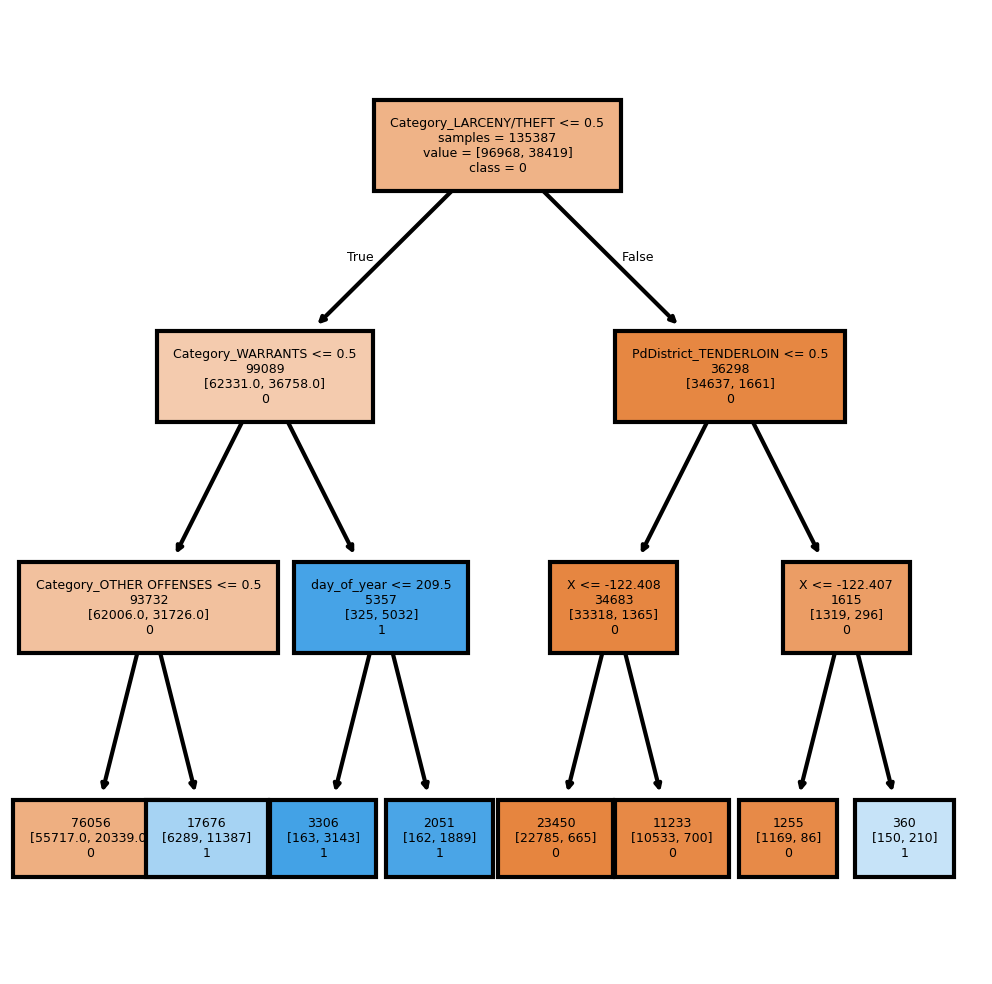

In [8]:
#--------------
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

plot = plt.subplots(figsize = (4,4), dpi=300)[0]
plot = plot_tree(model,
                fontsize=3,
                feature_names = features, 
                class_names = ['0','1'], # class_names in ascending numerical order 
                label="root",
                impurity=False,
                filled=True) 
plt.show()

All of the blue-colored boxes correspond to prediction that a crime would be resolved. 

Take a look at the tree to learn what it thinks are important for predicting an outcome. Compare this to the graphs we made earlier. Can you see a relationship between the two?

The score we have isn't bad, but the tree is pretty simple. Let's see if we can do better.

## Improving performance through architecture

We'll try and improve our model's performance by changing its architecture. Let's focus on the ``maximum_depth`` parameter. 

Our previous tree was relatively simple and shallow with a ``maximum_depth = 3``. Let's see what happens if we increase it to 100:

In [9]:
# fit a very deep tree
model = sklearn.tree.DecisionTreeClassifier(random_state=1, max_depth=100)

train_accuracy, test_accuracy = fit_and_test_model(model)
print("Train accuracy", train_accuracy)
print("Test accuracy", test_accuracy)

Train accuracy 0.9995864881946777
Test accuracy 0.7767968524220694


As you can imagine, a tree with a ``maximum_depth = 100`` is big. In fact, it's too big to visualize here, so let's jump straight into seeing how the new model works on our training data.

Both the training and test accuracy have increased a lot. The training, however, has increased much more. While we're happy with the improvement in test accuracy, this is a clear sign of _overfitting_.

Overfitting with decision trees becomes even more obvious when we have more typical (smaller) sized datasets. Let's rerun the previous exercise, but with only 100 training samples:

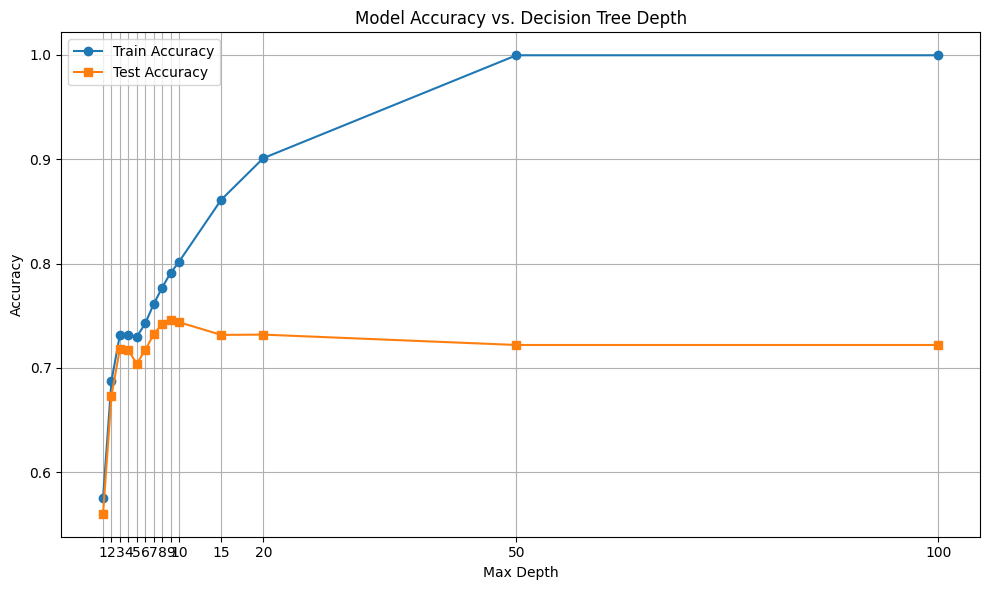

In [10]:
# Temporarily shrink the training set to 10000
# for this exercise to see how pruning is important
# even with moderately large datasets
full_training_set = train
train = train[:10000]


# Loop through the values below and build a model
# each time, setting the maximum depth to that value 
max_depth_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,15, 20, 50, 100]
accuracy_trainset = []
accuracy_testset = []
for depth in max_depth_range:
    # Create and fit the model
    prune_model = sklearn.tree.DecisionTreeClassifier(random_state=1, max_depth=depth)

    # Calculate and record its sensitivity
    train_accuracy, test_accuracy = fit_and_test_model(prune_model)
    accuracy_trainset.append(train_accuracy)
    accuracy_testset.append(test_accuracy)

# Plot the sensitivity as a function of depth  
pruned_plot = pandas.DataFrame(dict(max_depth=max_depth_range, accuracy=accuracy_trainset))

plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, accuracy_trainset, marker='o', label='Train Accuracy')
plt.plot(max_depth_range, accuracy_testset, marker='s', label='Test Accuracy')

plt.title('Model Accuracy vs. Decision Tree Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(max_depth_range)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Roll the training set back to the full thing
train = full_training_set

The model performs badly on the test data. With reasonable sized datasets, _decision trees_ are notoriously prone to _overfitting_. In other words, they tend to fit very well to the data on which they're trained, but generalize very poorly to unknown data. This gets worse the deeper the tree gets or the smaller the training set gets. Let's see if we can mitigate this.

## Pruning a tree

_Pruning_ is the process of simplifying a _decision tree_ so that it gives the best classification results while simultaneously reducing overfitting. There are two types of pruning: _pre-pruning_ and _post-pruning_. 

_Pre-pruning_ involves restricting the model during training so that it doesn't grow larger than is useful. We will cover this next.

_Post-pruning_ is when we simplify the tree after training it. It doesn't involve making any design decisions ahead of time, but simply optimizing the existing model. This is a valid technique but is quite involved, and so we won't cover it here due time constraints.

## Prepruning

We can perform pre-pruning by generating many models, each with different ``max_depth`` parameters. For each, we're recording the _balanced accuracy_ for the _test set_. To show that this is important even with quite large datasets, we'll work with 10,000 samples here.


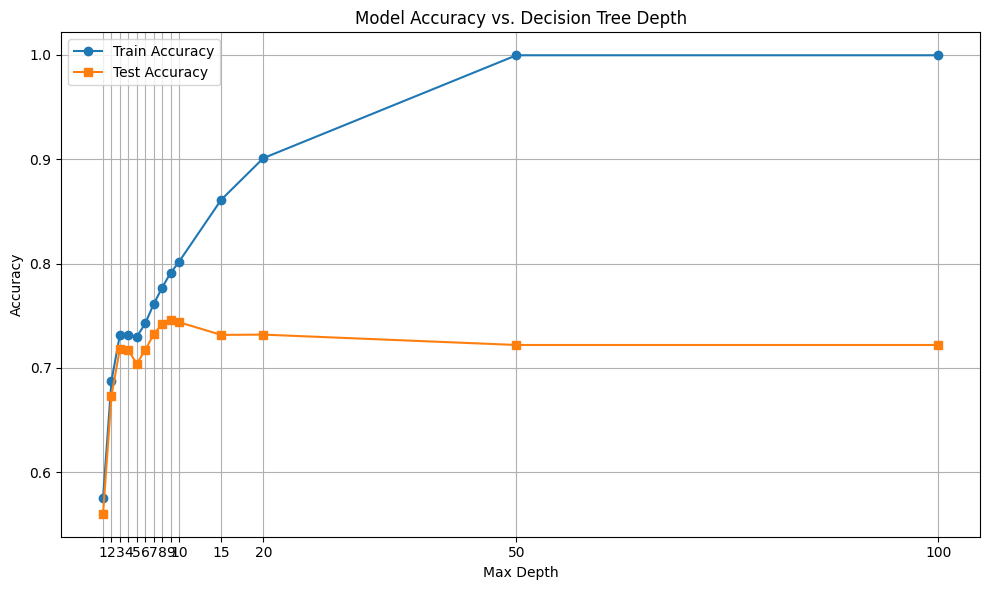

In [11]:
# Temporarily shrink the training set to 10000
# for this exercise to see how pruning is important
# even with moderately large datasets
full_training_set = train
train = train[:10000]


# Loop through the values below and build a model
# each time, setting the maximum depth to that value 
max_depth_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,15, 20, 50, 100]
accuracy_trainset = []
accuracy_testset = []
for depth in max_depth_range:
    # Create and fit the model
    prune_model = sklearn.tree.DecisionTreeClassifier(random_state=1, max_depth=depth)

    # Calculate and record its sensitivity
    train_accuracy, test_accuracy = fit_and_test_model(prune_model)
    accuracy_trainset.append(train_accuracy)
    accuracy_testset.append(test_accuracy)

# Plot the sensitivity as a function of depth  
pruned_plot = pandas.DataFrame(dict(max_depth=max_depth_range, accuracy=accuracy_trainset))

plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, accuracy_trainset, marker='o', label='Train Accuracy')
plt.plot(max_depth_range, accuracy_testset, marker='s', label='Test Accuracy')

plt.title('Model Accuracy vs. Decision Tree Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(max_depth_range)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Roll the training set back to the full thing
train = full_training_set

We can see from our plot that the best _accuracy_ is obtained for a ``max_depth`` of about 10. We're looking to simplify our tree, so we pick ``max_depth = 10`` for our final _pruned_ tree:

In [12]:
# Temporarily shrink the training set to 10000
# for this exercise to see how pruning is important
# even with moderately large datasets
full_training_set = train
train = train[:10000]


# Not-pruned
model = sklearn.tree.DecisionTreeClassifier(random_state=1)
train_accuracy, test_accuracy = fit_and_test_model(model)
print("Unpruned Train accuracy", train_accuracy)
print("Unpruned Test accuracy", test_accuracy)


# re-fit our final tree to print out its performance
model = sklearn.tree.DecisionTreeClassifier(random_state=1, max_depth=10)
train_accuracy, test_accuracy = fit_and_test_model(model)
print("Train accuracy", train_accuracy)
print("Test accuracy", test_accuracy)

# Roll the training set back to the full thing
train = full_training_set

Unpruned Train accuracy 0.9996434937611408
Unpruned Test accuracy 0.7219189452075965
Train accuracy 0.8016027915999302
Test accuracy 0.7437900187051387


Our new and improved _pruned_ model shows a marginally better _balanced accuracy_ on the _test set_ and much worse performance on the _training set_ than the model that isn't pruned. This means our pruning has significantly reduced overfitting.

If you'd like, go back and change the number of samples to 100 and notice how the optimal `max_depth` changes. Think about why this might be (hint: model complexity versus sample size) .

Another option that you might like to play with is how many features are entered into the tree. You can observe similar patterns of overfitting by manipulating this. In fact, the number and type of the features provided to a decision tree can be even more important than its sheer size.

## Summary

In this unit, we covered the following topics:
 - Using visualization techniques to gain insights into our data
 - Building a simple _decision tree_ model
 - Using the trained model to predict labels
 - _Pruning_ a _decision tree_ to reduce the effects of overfitting
